# Classic MCEliece

## Wstęp

Pierwszy kryprosystem klucza publicznego oparty na metodzie *code-based* został wprowadzony w 1978 roku przez `McEliece`. Klucz publiczny to losowy binarny kod Goppa. Szyfrogram to przesyłana wiadomość (klucz sesji, o czym później) wraz z losowym szumem. Klucz prywatny pozwala na odszyfrowanie szyfrogramu i wyekstrachowanie wiadomości z szumu.

Ten kryptosystem jest jednokierunkowy (*one-way*) co oznacza, że nie da się odzyskać zaszyfrowanego tekstu za pomocą szyfrogramu i klucza publicznego, jeśli tekst jest losowo wybrany. Jedną z zalet tego kryptosystemu jest to jak dawno powstał. Na przestrzeni 40 lat powstało wiele prac, które sprawdzały bezpieczeństwo tego systemu. Oryginalnie, algorytm zapewnia bezpieczeństwo na poziomie 264. Jednakże modyfikacja parametrów pozwala uzyskać większe bezpieczeństwo, co stawia ten system jako kandydata dla post-kwantowej rzeczywistości. Przez wiele lat istnienia, powstały pracę nawiązujące do algorytmu `McEliece`, co spowodowało powstanie bardzo wydajnych implementacji. 

`Classic McEliece` jest algorytmem implementującym KEM, który jest *IND-CCA2* bezpieczny na bardzo wysokim poziomie. Model KEM powstał na bazie PKE (*Public-Key Encryption*), które jest *OW-CPA* bezpieczne. Pochodzi ono z pracy Niederreitera, którt stworzył wersję `dual-McEliece`, korzystającą z kodów *Goppa*. Algorytm `Classic McEliece` został tak zaprojektowany, aby spełniać wszystkie wymagania stawiane przed post-kwantowymi kryptosystemami.

## KEM

KEM (*Key Encapsulation Mechanism*) powstał na bazie schematu PKE (*Public-Key Encryption*). Składa się on z trzech algorytmów: `KeyGen` (generowania klucza), `Encap` (enkapsulacji) i `Decap` (dekapsulacji). Generowanie klucza jest algorytmem probailistycznym, jako parametr przyjmuje parametr bezpieczeństwa i zwraca klucz publiczny i prywatny. Algorytm enkapsulacji na podstawie klucza publicznego tworzy klucz sesji i zwraca parę klucz i szyfrogram. Dekapsulacja polega na wydobyciu z szyfrogramu klucza sesji za pomocą klucza prywatnego.

Algorytm KEM był kandydatem w drugiej rundzie konkursu NIST na post-kwantowy kryptosystem. KEM składa się z 4 kroków:
1. Alicja prosi Boba o ustanowienie klucza sesji za pomocą algorytmu `Classic McEliece`.
2. Bob genereuje parę kluczy za pomocą funkcji `KeyGen` i przekazuje klucz publiczny do Alicji.
3. Alicja doknuje enkapsulacji za pomocą otrzymanego klucza publicznego. W wyniku algorytmu otrzymuje klucz sesji oraz szyfrogram. Szyfrogram zostaje przekazany Bobowi.
4. Bob dokonuje dekapsulacji szyfrogramu za pomocą klucza prywatnego i tworzy swój klucz sesji. Jeśli wszystko poszło prawidłowo jest on identyczny z kluczem Alicji.

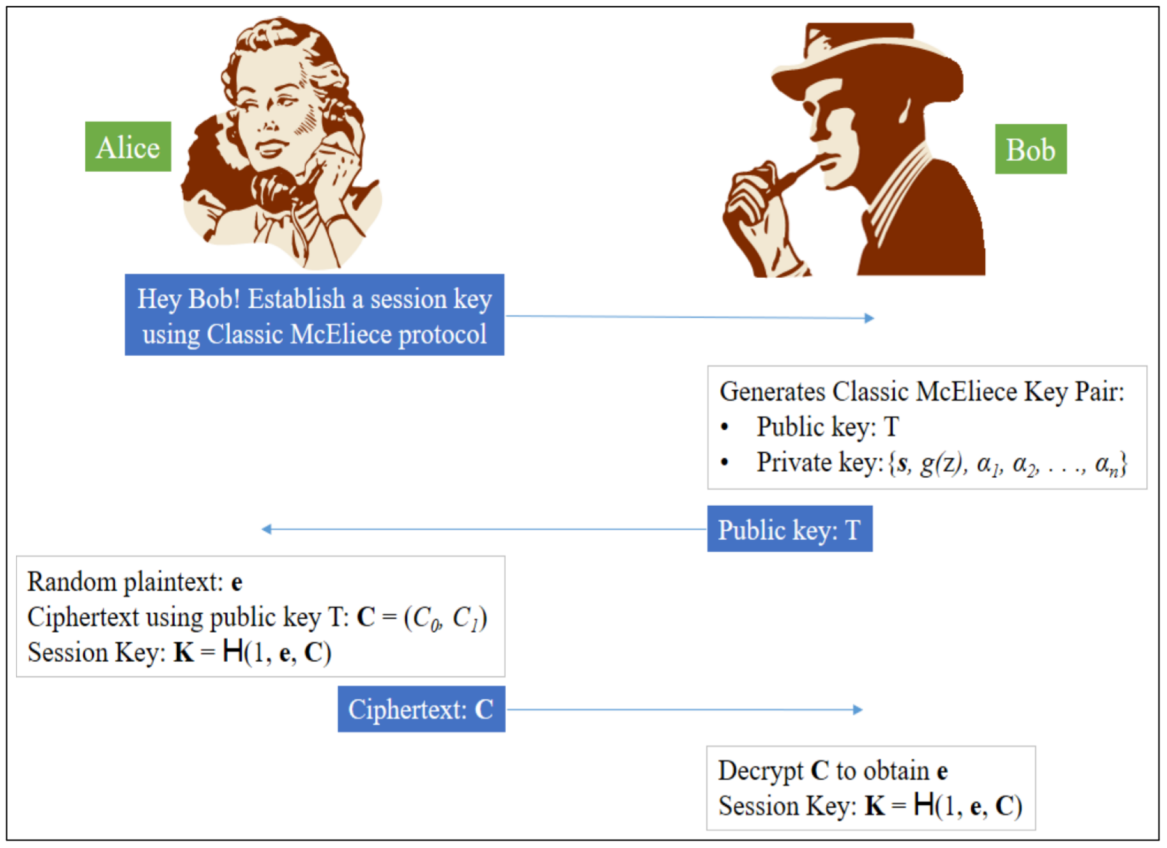


Na koniec tego procesu Alicja i Bob posiadają identyczny klucz sesji, który nie jest znany dla innych aktorów. Mogą wykorzystać ten klucz do szyfrowania symetrycznego wiadomości.

## Parametry

Do konkursu NIST zostały zgłoszone dwie wersje parametrów `mceliece6960119` i `mceliece8192128`. Pierwsza zapewnia bezpieczeństwo równe 128, natomiast druga 256. W implemenatcji wykorzystano parametry zgodne z `mceliece6960119`. Zostało to opisane następująco w dokumentacji:  
*KEM with $m = 13$, $n = 6960$, $t = 119$. Field polynomials $f(z) = z^{13} + z^4 + z^3 + z + 1$ and $F(y) = y^{119} + y^8 + 1$*.  
Obydwie wersje korzystją z domyślnych wartości dla parametrów $\mu = 0$ i $\nu = 0$. Oznacza to, że macierz, która pojawia się w algorytmie, będzie kwadratowa i nieosobliwa. W poniższej implementacji zostało wykorzystane to założenie.

In [ ]:
import hashlib as hl
import random

In [ ]:
m = 13
n = 6960
t = 119

q = pow(2, m)
k = n - m * t
tau = 2 * t
l = 256 # length in bits
sigma_1 = m
sigma_2 = 2 * m
G_size = n + sigma_2 * q + sigma_1 * q + l

def H(s, v, C):
    input = s.to_bytes()

    pad = [0] * ((8 * (n // 8 + 1) - n) % 8)
    v = pad + v
    for i in range(0, len(v), 8):
        bits = v[i:i + 8]
        num = 0
        for b in bits:
            num *= 2
            num += b
        input += num.to_bytes()

    pad = [0] * ((8 * (m * t // 8 + 1) - m * t) % 8)
    C = pad + C
    for i in range(0, len(C), 8):
        bits = C[i:i + 8]
        num = 0
        for b in bits:
            num *= 2
            num += b
        input += num.to_bytes()
    
    res = hl.sha256(input).hexdigest()
    return res

def G(delta):
    num = 0
    for b in delta:
        num *= 2
        num += b
    size = G_size // 8 + 1
    res = hl.shake_256(num.to_bytes(l // 8)).digest(size)
    binary = format(int.from_bytes(res), f'{size * 8}b').replace(' ', '0')
    binary = [1 if s == '1' else 0 for s in binary]
    return binary[:G_size]

## Działania w ciele skończonym

Implementacja działań w ciele skończonym na podstawie implementacji referencyjnej algorytmu `Classic McEliece`.

ToDo: wyjaśnienie jak i czemu to działa

In [ ]:
# def gf_iszero(a):
#     return (a - 1) >> 19

# def gf_add(a, b):
#     return a ^ b

# def gf_mul(a, b):
#     tmp = a * (b & 1)
#     for i in range(1, m):
#         tmp ^= a * (b & (1 << i))
    
#     t = tmp & 0x1FF0000
#     tmp ^= (t >> 9) ^ (t >> 10) ^ (t >> 12) ^ (t >> 13)
#     t = tmp & 0x000E000
#     tmp ^= (t >> 9) ^ (t >> 10) ^ (t >> 12) ^ (t >> 13)
    
#     return tmp & (q - 1)

# # return a ** b; b in N
# def gf_pow(a, b):
#     if b == 0:
#         return 1
#     res = a
#     for _ in range(b - 1):
#         res = gf_mul(res, a)
#     return res

# # return (a^2)^2
# def gf_sq2(a):
#     B = [0x1111111111111111,
#          0x0303030303030303,
#          0x000F000F000F000F,
#          0x000000FF000000FF]
    
#     M = [0x0001FF0000000000,
#          0x000000FF80000000,
#          0x000000007FC00000,
#          0x00000000003FE000]
    
#     a = (a | (a << 24)) & B[3]
#     a = (a | (a << 12)) & B[2]
#     a = (a | (a << 6)) & B[1]
#     a = (a | (a << 3)) & B[0]
    
#     for i in range(4):
#         t = a & M[i]
#         a ^= (t >> 9) ^ (t >> 10) ^ (t >> 12) ^ (t >> 13)
    
#     return a & (q - 1)
    
# # return (a^2) * b
# def gf_sqmul(a, b):
#     M = [0x0000001FF0000000,
#          0x000000000FF80000,
#          0x000000000007E000]
    
#     x = (b << 6) * (a & (1 << 6))
    
#     a ^= (a << 7)
    
#     x ^= (b * (a & (0x04001)))
#     x ^= (b * (a & (0x08002))) << 1
#     x ^= (b * (a & (0x10004))) << 2
#     x ^= (b * (a & (0x20008))) << 3
#     x ^= (b * (a & (0x40010))) << 4
#     x ^= (b * (a & (0x80020))) << 5
    
#     for i in range(3):
#         t = x & M[i]
#         x ^= (t >> 9) ^ (t >> 10) ^ (t >> 12) ^ (t >> 13)
        
#     return x & (q - 1)


# # return ((a^2)^2)*b
# def gf_sq2mul(a, b):
#     M = [0x1FF0000000000000,
#          0x000FF80000000000,
#          0x000007FC00000000,
#          0x00000003FE000000,
#          0x0000000001FE0000,
#          0x000000000001E000]
    
#     x = (b << 18) * (a & (1 << 6))
    
#     a ^= (a << 21)
    
#     x ^= (b * (a & (0x010000001)))
#     x ^= (b * (a & (0x020000002))) << 3
#     x ^= (b * (a & (0x040000004))) << 6
#     x ^= (b * (a & (0x080000008))) << 9
#     x ^= (b * (a & (0x100000010))) << 12
#     x ^= (b * (a & (0x200000020))) << 15
    
#     for i in range(6):
#         t = x & M[i]
#         x ^= (t >> 9) ^ (t >> 10) ^ (t >> 12) ^ (t >> 13)
        
#     return x & (q - 1)

# # return num / den
# def gf_frac(den, num):
#     tmp_11 = gf_sqmul(den, den)
#     tmp_1111 = gf_sq2mul(tmp_11, tmp_11)
#     res = gf_sq2(tmp_1111)
#     res = gf_sq2mul(res, tmp_1111)
#     res = gf_sq2(res)
#     res = gf_sq2mul(res, tmp_1111)
    
#     return gf_sqmul(res, num)

# def gf_inv(a):
#     return gf_frac(a, 1)

# # A, B in GF((2^m)^t)
# # return A * B
# def GF_mul(A, B):
#     prod = [0] * (t * 2 - 1)
#     for i in range(t):
#         for j in range(t):
#             prod[i + j] ^= gf_mul(A[i], B[j])

#     for i in range((t - 1) * 2, t - 1, -1):
#         prod[i - t + 8] ^= prod[i]
#         prod[i - t] ^= prod[i]

#     return prod[:t]

In [ ]:
def gf_iszero(a):
    return (a - 1) >> 19

def gf_add(a, b):
    return a ^ b

def gf_mul(a, b):
    tmp = a * (b & 1)
    for i in range(1, m):
        tmp ^= a * (b & (1 << i))
    
    t = tmp & 0x7FC000
    tmp ^= t >> 9
    tmp ^= t >> 12

    t = tmp & 0x3000
    tmp ^= t >> 9
    tmp ^= t >> 12
    
    return tmp & (q - 1)

# return a ** b; b in N
def gf_pow(a, b):
    if b == 0:
        return 1
    res = a
    for _ in range(b - 1):
        res = gf_mul(res, a)
    return res

def gf_sq(a):
    B = [0x55555555,
         0x33333333,
         0x0F0F0F0F,
         0x00FF00FF]

    
    a = (a | (a << 8)) & B[3]
    a = (a | (a << 4)) & B[2]
    a = (a | (a << 2)) & B[1]
    a = (a | (a << 1)) & B[0]
    
    t = a & 0x7FC000
    a ^= t >> 9
    a ^= t >> 12

    t = a & 0x3000
    a ^= t >> 9
    a ^= t >> 12
    
    return a & (q - 1)

def gf_frac(den, num):
    return gf_mul(gf_inv(den), num)

def gf_inv(a):
    res = gf_sq(a)
    tmp_11 = gf_mul(res, a)

    res = gf_sq(tmp_11)
    res = gf_sq(res)
    tmp_1111 = gf_mul(res, tmp_11)

    res = gf_sq(tmp_1111)
    res = gf_sq(res)
    res = gf_sq(res)
    res = gf_sq(res)
    res = gf_mul(res, tmp_1111)

    res = gf_sq(res)
    res = gf_sq(res)
    res = gf_mul(res, tmp_11)

    res = gf_sq(res)
    res = gf_mul(res, a)

    return gf_sq(res)

# A, B in GF((2^m)^t)
# return A * B
def GF_mul(A, B):
    prod = [0] * (t * 2 - 1)
    for i in range(t):
        for j in range(t):
            prod[i + j] ^= gf_mul(A[i], B[j])

    for i in range((t - 1) * 2, t - 1, -1):
        prod[i - t + 3] ^= prod[i]
        prod[i - t + 1] ^= prod[i]
        prod[i - t] ^= gf_mul(prod[i], 2)

    return prod[:t]

## Funkcje pomocnicze

Do zaimplementowania właściwych algorytmów potrzebujemy kilku funkcji pomocniczych: `MatGen`, `Encode`, `Decode`, `Irreducible`, `FieldOrdering`, `SeededKeyGen`, `FixedWeight`.

### MatGen

The following algorithm MatGen takes as input $\Gamma = (g, α_0, α_1, . . . , α_{n−1})$ where
- $g$ is a monic irreducible polynomial in $F_q[x]$ of degree $t$ and
- $α_0, α_1, . . . , α_{n−1}$ are distinct elements of $F_q$.  

The algorithm output $MatGen(\Gamma)$ is either $⊥$ or
of the form $(T, \Gamma)$, where $T$ is an $mt × k$ matrix over $F_2$. Here is the algorithm:
1. Compute the $t × n$ matrix $H_q = {h_{i,j} }$ over $F_q$, where $h_{i,j} = \frac{α_j^i}{g(α_j)}$ for $i = 0, . . . , t − 1$
and $j = 0, . . . , n − 1$.
2. Form an $mt × n$ matrix H over $F_2$ by replacing each entry $u_0 + u_1z + · · · + u_{m−1}z^{m−1}$
of H_q with a column of $m$ bits $u_0, u_1, . . . , u_{m−1}$.
3. Reduce H to systematic form $(I_{mt} | T )$, where $I_{mt}$ is an $mt × mt$ identity matrix. If
this fails, return $⊥$.
4. Return $(T, \Gamma)$.

In [ ]:
def eval(poly):
    def _eval(x):
        res = 0
        for a in poly[::-1]:
            res = gf_mul(res, x)
            res = gf_add(res, a)
        return res
    return _eval

def gauss_reduce(matrix):
    x_size = len(matrix)
    y_size = len(matrix[0])
    for i in range(x_size):
        if matrix[i][i] == 0:
            tmp = i
            for j in range(i+1, x_size):
                if matrix[j][i] != 0:
                    tmp = j
                    break
            matrix[i], matrix[tmp] = matrix[tmp], matrix[i]
        a = matrix[i][i]
        assert a != 0, "matrix is not reducible"
        assert a == 1, "a is not in F_2"
        for j in range(x_size):
            if i == j:
                continue
            b = matrix[j][i]
            if b == 0:
                continue
            assert b == 1, "b is not in F_2"
            for e in range(i, y_size):
                matrix[j][e] ^= matrix[i][e]
    
    for i in range(x_size):
        assert matrix[i][i] == 1, "matrix is not reducible"
    
    return [row[x_size:] for row in matrix]

def MatGen(gamma):
    print(f"MatGen: Start with gamma = {gamma}")
    g = eval(gamma[0])

    H = [[None] * n for _ in range(m * t)]

    for j in range(n):
        alfa = gamma[j+1]
        alfa_pow = 1
        alfa_g = g(alfa)
        for i in range(t):
            num = gf_frac(alfa_g, alfa_pow)
            binary = format(num, f'{m}b').replace(' ', '0')
            for e, b in enumerate(binary[::-1]):
                H[i * m + e][j] = 1 if b == '1' else 0
            alfa_pow = gf_mul(alfa_pow, alfa)

    print("MatGen: H matrix is prepared, go to gauss reduction")
    
    try:
        T = gauss_reduce(H)
    except Exception as ex:
        print(ex)
        return None
    
    print(f"MatGen: End and return T = {T}")
    return T, gamma

### Encode

The following algorithm $Encode$ takes two inputs: 
- a weight-t column vector $e ∈ F^n_2$; 
- and a public key $T$, i.e., an $mt × k$ matrix over $F_2$.

The algorithm output $Encode(e, T )$ is a vector $C ∈ F^{mt}_2$. Here is the algorithm:
1. Define $H = (I_{mt} | T )$.
2. Compute and return $C = He ∈ F^{mt}_2$

In [ ]:
def dot(u, v):
    res = 0
    for x, y in zip(u, v):
        res ^= u * v
    return res

def mul(A, x):
    y = [None] * (len(A))
    for i in range(len(A)):
        y[i] = dot(A[i], x)
    return y

def Encode(e, T):
    print(f"Encode: Start with e = {e}")
    H = [None] * (m * t)
    for i, row in enumerate(T):
        prefix = [0] * (m * t)
        prefix[i] = 1
        H[i] = prefix + row
    print("Encode: H matrix is prepared, go to multiply with vector e")
    C = mul(H, e)
    print(f"Encode: End and return C = {C}")
    return C

### Decode

The following algorithm $Decode$ decodes $C ∈ F^{mt}_2$ to a word $e$ of Hamming weight $wt(e) = t$ 
with $C = He$ if such a word exists; otherwise it returns failure.  
Formally, $Decode$ takes two inputs: 
- a vector $C ∈ F^{mt}_2$;
- and $\Gamma'$, the last component of $MatGen(\Gamma)$ for some $\Gamma$ such that $MatGen(\Gamma) != ⊥$.

Write $T$ for the first component of $MatGen(\Gamma)$. By definition of $MatGen$:
- $T$ is an $mt × k$ matrix over $F_2$;
- $\Gamma'$ has the form $(g, α'_0, α'_1, . . . , α'_{n−1})$;
- $g$ is a monic irreducible polynomial in $F_q[x]$ of degree $t$;
- $α'_0, α'_1, . . . , α'_{n−1}$ are distinct elements of $F_q$.

There are two possibilities for $Decode(C, \Gamma')$:
- If $C = Encode(e, T)$ then $Decode(C, \Gamma') = e$. In other words, if there exists a weight-t vector $e ∈ F^n_2$
such that $C = He$ with $H = (I_{mt} | T )$, then $Decode(C, \Gamma') = e$.
- If $C$ does not have the form $He$ for any weight-t vector $e ∈ F^n_2$, then $Decode(C, \Gamma') = ⊥$.

Here is the algorithm:
1. Extend $C$ to $v = (C, 0, . . . , 0) ∈ F^n_2$ by appending $k$ zeros.
2. Find the unique $c ∈ F^n_2$ such that (1) $Hc = 0$ and (2) $c$ has Hamming distance $≤t$ from $v$. 
If there is no such $c$, return $⊥$. (For the fact that $c$ is unique if it exists, and the fact
that $c$ always exists when $C$ is output by $Encap$, see the separate “guide for security
reviewers” document.)
3. Set $e = v + c$.
4. If $wt(e) = t$ and $C = He$, return $e$. Otherwise return $⊥$.

In [ ]:
def hamming_distance(u, v):
    dis = 0
    for x, y in zip(u, v):
        if x == y:
            continue
        dis += 1
    return dis

def hamming_weight(u):
    v = [0] * len(u)
    return hamming_distance(u, v)

def Decode(C, gamma_prim):
    print("Decode: Start function")
    T, gamma_bis = MatGen(gamma_prim)
    H = [None] * (m * t)
    for i, row in enumerate(T):
        prefix = [0] * (m * t)
        prefix[i] = 1
        H[i] = prefix + row
    
    print(f"Decode: H is prepared")
    v = C + ([0] * k)
    c = [0] * n # ToDo
    e = [None] * n
    for i, (x, y) in enumerate(zip(v, c)):
        e[i] = x ^ y

    if hamming_weight(e) != t:
        return None

    C_prim = mul(H, e)
    if C_prim != C:
        return None
    
    print(f"Decode: End and return e = {e}")

    return e

### Irreducible

The following algorithm $Irreducible$ takes a string of $σ_1t$ input bits $d_0, d_1, . . . , d_{σ_1t−1}$. It
outputs either $⊥$ or a monic irreducible degree-t polynomial $g ∈ F_q[x]$. Here is the algorithm:
1. Define $β_j = ∑^{m−1}_{i=0} d_{σ_1j+i}z^i$ for each $j ∈ {0, 1, . . . , t − 1}$. 
(Within each group of $σ_1$ input bits, this uses only the first $m$ bits. The algorithm ignores the remaining bits.)
2. Define $β = β_0 + β_1y + · · · + β_{t−1}y^{t−1} ∈ F_q[y] / F(y)$.
3. Compute the minimal polynomial $g$ of $β$ over $F_q$. (By definition $g$ is monic and irreducible, and $g(β) = 0$.)
4. Return $g$ if $g$ has degree $t$. Otherwise return $⊥$.

In [ ]:
def transpose(matrix):
    x_size = len(matrix)
    y_size = len(matrix[0])
    mat = [[None] * x_size for _ in range(y_size)]
    for i in range(x_size):
        for j in range(y_size):
            mat[j][i] = matrix[i][j]
    return mat

def gf_gauss_reduce(matrix):
    x_size = len(matrix)
    y_size = len(matrix[0])
    for i in range(x_size):
        if matrix[i][i] == 0:
            tmp = i
            for j in range(i+1, x_size):
                if matrix[j][i] != 0:
                    tmp = j
                    break
            matrix[i], matrix[tmp] = matrix[tmp], matrix[i]
        a = matrix[i][i]
        assert a != 0, "matrix is not reducible"
        inv_a = gf_inv(a)
        for e in range(i, y_size):
            matrix[i][e] = gf_mul(matrix[i][e], inv_a)
        for j in range(i+1, x_size):
            b = matrix[j][i]
            if b == 0:
                continue
            for e in range(i, y_size):
                matrix[j][e] ^= gf_mul(matrix[i][e], b) #?
    
    for i in range(x_size - 1, -1, -1):
        for j in range(i - 1, -1, -1):
            b = matrix[j][i]
            if b == 0:
                continue
            for e in range(i, y_size):
                matrix[j][e] ^= gf_mul(matrix[i][e], b)
    
    for i in range(x_size):
        assert matrix[i][i] == 1, "matrix is not reducible"
    
    return [row[x_size:] for row in matrix]

def Irreducible(input):
    print(f"Irreducible: Start function")
    beta = [None] * t
    for j in range(t):
        # beta_j = []
        beta_j = 0
        for i in range(m-1, -1, -1):
            # beta_j.append(input[sigma_1 * j + i])
            beta_j *= 2
            beta_j += input[sigma_1 * j + i]
        beta[j] = beta_j
    
    matrix = [None] * (t + 1)
    matrix[0] = [1] + ([0] * (t - 1))
    matrix[1] = beta.copy()
    for j in range(2, t+1):
        matrix[j] = GF_mul(matrix[j-1], beta)

    matrix = transpose(matrix)
    try:
        res = gf_gauss_reduce(matrix)
    except Exception as ex:
        print(ex)
        return None
    g = [el[0] for el in res]
    if g[t-1] == 0:
        return None
    print(f"Irreducible: End and return g = {g}")
    return g

### FieldOrdering

The following algorithm $FieldOrdering$ takes a string of $σ_2q$ input bits. It outputs either
$⊥$ or a sequence $(α_0, α_1, . . . , α_{q−1})$ of $q$ distinct elements of $F_q$. Here is the algorithm:
1. Take the first $σ_2$ input bits $b_0, b_1, . . . , b_{σ_2−1}$ as a $σ_2$-bit integer $a_0 = b_0 + 2b_1 + · · · + 2^{σ_2−1}b_{σ_2−1}$,
take the next $σ_2$ bits as a $σ_2$-bit integer $a_1$, and so on through $a_{q−1}$.
2. If $a_0, a_1, . . . , a_{q−1}$ are not distinct, return $⊥$.
3. Sort the pairs $(a_i, i)$ in lexicographic order to obtain pairs $(a_{π(i)}, π(i))$ where $π$ is a
permutation of ${0, 1, . . . , q − 1}$.
4. Define $α_i = ∑^{m-1}_{j=0} π(i)_j · z^{m−1−j}$
where $π(i)_j$ denotes the $j$th least significant bit of $π(i)$. (Recall that the finite field $F_q$
is constructed as $F_2[z] / f(z)$.)
5. Output $(α_0, α_1, . . . , α_{q−1})$.

In [ ]:
def FieldOrdering(input):
    print(f"FieldOrdering: Start function")
    a_list = []
    for i in range(0, sigma_2 * q, sigma_2):
        bits = input[i:i + sigma_2]
        num = 0
        for b in bits[::-1]:
            num *= 2
            num += b
        a_list.append(num)


    a_pairs = [(a, i) for i, a in enumerate(a_list)]
    a_pairs.sort()
    for i in range(q-1):
        if a_pairs[i][0] == a_pairs[i+1][0]:
            return None
    perm = [i for _, i in a_pairs]
    print(f"FieldOrdering: End and return perm = {perm}")
    return perm

### SeededKeyGen

The following algorithm $SeededKeyGen$ takes an $l$-bit input $δ$. It outputs a public key
and private key. Here is the algorithm:
1. Compute $E = G(δ)$, a string of $n + σ_2q + σ_1t + l$ bits.
2. Define $δ'$ as the last $l$ bits of $E$.
3. Define $s$ as the first $n$ bits of $E$.
4. Compute $α_0, . . . , α_{q−1}$ from the next $σ_2q$ bits of $E$ by the $FieldOrdering$ algorithm.
If this fails, set $δ ← δ'$ and restart the algorithm.
5. Compute $g$ from the next $σ_1t$ bits of $E$ by the $Irreducible$ algorithm. If this fails,
set $δ ← δ'$ and restart the algorithm.
6. Define $Γ = (g, α_0, α_1, . . . , α_{n−1})$. (Note that $α_n, . . . , α_{q−1}$ are not used in $Γ$.)
7. Compute $(T, Γ') ← MatGen(Γ)$. If this fails, set $δ ← δ'$ and restart
the algorithm.
8. Output $T$ as public key and $(δ, g, α, s)$ as private key, where $α = (α_0, . . . , α_{n−1}, α_n, . . . , α_{q−1})$.

In [ ]:
def SeededKeyGen(delta):
    print(f"SeededKeyGen: Start with delta = {delta}")
    delta_prim = delta
    while True:
        delta = delta_prim
        print(f"SeededKeyGen: Start in loop delta = {delta}")
        E = G(delta)
        delta_prim = E[-l:]
        s = E[:n]
        st = n

        alfas = FieldOrdering(E[st:st + sigma_2 * q])
        print(f"SeededKeyGen: After FieldOrdering alfas = {alfas}")
        st += sigma_2 * q
        if alfas is None:
            continue

        g = Irreducible(E[st:st + sigma_1 * t])
        print(f"SeededKeyGen: After Irreducible g = {g}")
        st += sigma_1 * t
        if g is None:
            continue

        gamma = [g] + alfas[:n]
        mat_gen = MatGen(gamma)
        print(f"SeededKeyGen: After MatGen res = {mat_gen}")
        if mat_gen is None:
            continue
        T, gamma_prim = mat_gen

        print(f"SeededKeyGen: End function")

        return T, (delta, g, alfas, s)

### FixedWeight

The following randomized algorithm $FixedWeight$ takes no input. It outputs a vector $e ∈ F^n_2$ of weight $t$. 
The algorithm uses a precomputed integer $τ ≥ t$ defined below. Here is
the algorithm:
1. Generate $σ_1τ$ uniform random bits $b_0, b_1, . . . , b_{σ_1τ −1}$.
2. Define $dj = ∑^{m−1}_{i=0} b_{σ_1j+i}2^i$ for each $j ∈ {0, 1, . . . , τ − 1}$. (Within each group of $σ_1$
random bits, this uses only the first $m$ bits. The algorithm ignores the remaining bits.)
3. Define $a_0, a_1, . . . , a_{t−1}$ as the first $t$ entries in $d_0, d_1, . . . , d_{τ −1}$ in the range
${0, 1, . . . , n − 1}$. If there are fewer than $t$ such entries, restart the algorithm.
4. If $a_0, a_1, . . . , a_{t−1}$ are not all distinct, restart the algorithm.
5. Define $e = (e_0, e_1, . . . , e_{n−1}) ∈ F^n_2$ as the weight-t vector such that $e_{a_i} = 1$ for each $i$.
6. Return $e$.

The integer $τ$ is defined as $t$ if $n = q$; as $2t$ if $q/2 ≤ n < q$; as $4t$ if $q/4 ≤ n < q/2$; etc. All
of the selected parameter sets have $q/2 ≤ n ≤ q$, so $τ ∈ {t, 2t}$.

In [ ]:
def FixedWeight():
    while True:
        print(f"FixedWeight: Start in loop")
        bits = [random.randint(0, 1) for _ in range(sigma_1 * tau)]

        d_list = [None] * tau
        for j in range(tau):
            d_j = 0
            for i in range(m - 1, -1, -1):
                d_j *= 2
                d_j += bits[sigma_1 * j + i]
            d_list[j] = d_j
        
        a_list = d_list[:t]
        if len(a_list) != t:
            continue

        a_sorted = sorted(a_list)
        check = False
        for i in range(t-1):
            if a_sorted[i] == a_sorted[i + 1]:
                check = True
                break
        if check:
            continue

        e = [0] * n
        for a in a_list:
            e[a] = 1
        
        print(f"FixedWeight: End and return e = {e}")

        return e

## Algorytmy KEM

### KeyGen

The following randomized algorithm $KeyGen$ takes no input (beyond the parameters).
It outputs a public key and private key. Here is the algorithm, using a subroutine
$SeededKeyGen$:
1. Generate a uniform random $l$-bit string $δ$.
2. Output $SeededKeyGen(δ)$.

In [ ]:
def KeyGen():
    delta = [random.randint(0, 1) for _ in range(l)]
    return SeededKeyGen(delta)

### Encap

The following randomized algorithm $Encap$ takes as input a public key $T$. It outputs a
ciphertext $C$ and a session key $K$. Here is the algorithm:
1. Use $FixedWeight$ to generate a vector $e ∈ F^n_2$ of weight $t$.
2. Compute $C = Encode(e, T)$.
3. Compute $K = H(1, e, C)$.
4. Output ciphertext $C$ and session key $K$.

In [ ]:
def Encap(T):
    e = FixedWeight()
    C = Encode(e, T)
    K = H(1, e, C)
    return C, K, e

### Decap

The following algorithm $Decap$ takes as input a ciphertext $C$ and a private key, and outputs
a session key $K$. Here is the algorithm:
1. Set $b ← 1$.
2. Extract $s ∈ F^n_2$ and $Γ = (g, α_0, α_1, . . . , α_{n−1})$ from the private key.
3. Compute $e ← Decode(C, Γ)$. If $e = ⊥$, set $e ← s$ and $b ← 0$.
4. Compute $K = H(b, e, C)$.
5. Output session key $K$.

In [ ]:
def Decap(C, private_key, e):
    b = 1
    _, g, alfas, s = private_key
    gamma = (g, alfas[:n])
    # e = Decode(C, gamma)
    if e is None:
        e = s
        b = 0
    K = H(b, e, C)
    return K

## Komunikacja KEM

### Pierwszy krok - Alice

Wybór algorytmu i jego parametrów.

In [ ]:
# m = 4
# n = 16
# t = 2

# q = pow(2, m)
# k = n - m * t
# tau = t
# l = 256 # length in bits
# sigma_1 = m
# sigma_2 = 2 * m
# G_size = n + sigma_2 * q + sigma_1 * q + l

m = 12
n = 3488
t = 64

q = pow(2, m)
k = n - m * t
tau = 2 * t
l = 256 # length in bits
sigma_1 = m
sigma_2 = 2 * m
G_size = n + sigma_2 * q + sigma_1 * q + l

### Drugi krok - Bob

Generowanie klucza publicznego i prywatnego.

In [ ]:
public_key, private_key = KeyGen()

### Trzeci krok - Alice

Enkapsulacja klucza sesji.

In [ ]:
C, K, e = Encap(public_key)

### Czwarty krok - Bob

Dekapsulacja klucza sesji.

In [ ]:
K_prim = Decap(C, private_key, e)

In [ ]:
assert K == K_prim
print("Success, Session Keys are equal")

Alice i Bob posiadają identyczne tajne klucze sesji i mogą rozpocząć komunikację z wykorzystaniem szyfrowania symetrycznego.

## Testy